# References

Kaggle for data: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download and Jeff Prosise: https://github.com/jeffprosise/Deep-Learning/blob/master/Fraud%20Detection.ipynb 

At the end of the Lab, students should be able to

1. Use spaCy to examine PoS tags of a sentence.
2. Perform binary classification using a simple neural network.

In [ ]:
!python3 -m spacy download sv_core_news_sm

In [ ]:
import spacy
from spacy.lang.sv.examples import sentences 

nlp = spacy.load("sv_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Binary Classification example using creditcard dataset:

In [ ]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df = df.dropna()
df.head(10)

In [ ]:
df['Class'].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop(['Time', 'Class'], axis=1)    # drop these 2 columns
y = df['Class']                           # assign labels to y

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

For an example diagram of a neural network, see https://www.v7labs.com/blog/neural-network-architectures-guide 




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=29))    # Activation function defines the output of that node given an input or set of inputs
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizer is an algorithm that modifies the attributes of the neural network, such as weights and learning rate, to reduce the loss and improve the accuracy
model.summary()

In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Task

1. Perform binary classification on the IMDB dataset. Report your accuracy after 15 epochs and draw the confusion matrix to show the error analysis.
2. Repeat 1 using a different activation function from RELU and a different optimizer.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk import word_tokenize
import pandas as pd

In [ ]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    return data

In [ ]:
# Load preprocessed data (preprocessed by the function above)
data = pd.read_csv("IMDB Dataset.csv", delimiter=',', header=None)
data.columns = ['Sentence', 'Class']
data['Class'] = data['Class'].replace("positive", 1)
data['Class'] = data['Class'].replace("negative", 0)
data = preprocess_pandas(data, data.columns) # pre-process
data = data.iloc[1:]

In [ ]:
from sklearn.model_selection import train_test_split

training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.20,
    random_state=0,
    shuffle=True
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=5000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_) 
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

In [ ]:
device = torch.device('cuda')

In [67]:
network = nn.Sequential(
    nn.Linear(vocab_size, 256),
    nn.ReLU(),
    nn.Linear(256, 100), 
    nn.ReLU(), 
    nn.Linear(100, 1),
    nn.Sigmoid()
).to(device)

optimizer = torch.optim.Adam(network.parameters())

loss_function = torch.nn.BCELoss()

epochs = 15

network.train()
for epoch in range(epochs):
    for batch_nr, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        prediction = network(data).squeeze(1)
        labels = labels.to(torch.float32)
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',end='')

network.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    for batch_nr, (data, labels) in enumerate(val_loader):
        data = data.to(device)
        prediction = network(data)
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(prediction.detach().cpu().numpy() > 0.5) 
    
    for i in range(len(y_pred)):
        correct += int(y_pred[i] == y_true[i])
    total = len(y_true)
    print(f'\nThe accuracy of the network is {str(100*correct/total)[:4]}%.')

Epoch 15 [625/625] - Loss: 1.256399536941899e-056
The accuracy of the network is 87.8%.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mat = confusion_matrix(y_true, y_pred)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# RUN TWO

In [73]:
network = nn.Sequential(
    nn.Linear(vocab_size, 256),
    nn.GELU(),
    nn.Linear(256, 100), 
    nn.GELU(), 
    nn.Linear(100, 1),
    nn.Sigmoid()
).to(device)

optimizer = torch.optim.RMSprop(network.parameters())

loss_function = torch.nn.BCELoss()

epochs = 15

network.train()
for epoch in range(epochs):
    for batch_nr, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        prediction = network(data).squeeze(1)
        labels = labels.to(torch.float32)
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',end='')

network.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    for batch_nr, (data, labels) in enumerate(val_loader):
        data = data.to(device)
        prediction = network(data)
        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(prediction.detach().cpu().numpy() > 0.5) 
    
    for i in range(len(y_pred)):
        correct += int(y_pred[i] == y_true[i])
    total = len(y_true)
    print(f'\nThe accuracy of the network is {str(100*correct/total)[:4]}%.')

Epoch 15 [625/625] - Loss: 4.42517603005399e-0677
The accuracy of the network is 87.1%.


Text(113.9222222222222, 0.5, 'Actual label')

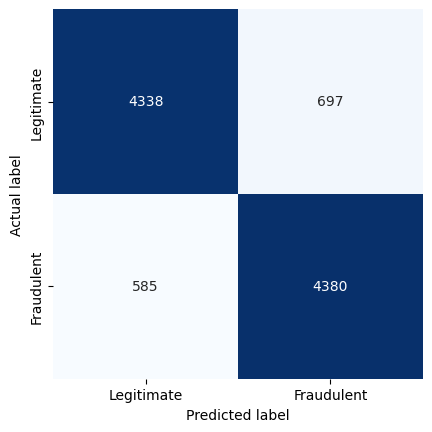

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mat = confusion_matrix(y_true, y_pred)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Grading questions (in addition to any relevant ones not listed below):

1. Run your code, go through it and explain what it does.
2. Is there any part of the code that may be optimized (made better)
3. What other challenges can this solution be adapted for?
4. Will you like to discuss the time & space complexities of parts of your solution (optional)?